---
# Sequential plotter
---

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from confusion_matrix import confusion_matrix
from sklearn.metrics import confusion_matrix as cf
from sklearn.feature_selection import SequentialFeatureSelector
import sys

"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [2]:
config = {
    "standardize" : True,
    "lda-reduce" : 4,
    "classifier" : "svm",
    "keep_features" : 10,
    "drop_8_18" : False,
    "direction" : ["forward", "backward"] 
}

In [3]:
# Load data sets
#trn_sel =  pd.read_csv(sys.path[0] + f"/../TrainingData/neodata/fault_all_10.csv")
trn_data = pd.read_csv(sys.path[0] + f"/../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(sys.path[0] + f"/../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(sys.path[0] + f"/../TestData/neodata/soltani_14d_nonoise_100.csv")
trn_sel = trn_data.iloc[::10,:]
trn_data = trn_data.iloc[::5,:]
vld_data = vld_data.iloc[::10,:]

if config["drop_8_18"]:
    trn_sel = [ (trn_sel['target'] != 8) & (trn_sel['target'] != 18) ]
    trn_data = [ (trn_data['target'] != 8) & (trn_data['target'] != 18) ]
    vld_data = [ (vld_data['target'] != 8) & (vld_data['target'] != 18) ]
    tst_data = [ (tst_data['target'] != 8) & (tst_data['target'] != 18) ]


# Separate into data and targets
y_sel = trn_sel.pop('target')
X_sel = trn_sel

y_trn = trn_data.pop('target')
X_trn = trn_data#.assign(single=np.ones((len(y_trn),)))

y_vld = vld_data.pop('target')
X_vld = vld_data#.assign(single=np.ones((len(y_vld),)))

y_tst = tst_data.pop('target')
X_tst = tst_data#.assign(single=np.ones((len(y_tst),)))

## Standardize data (z-norm)

In [4]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)
    X_sel_std = standardizer.transform(X_sel)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
    X_sel_std = pd.DataFrame(X_sel_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst
    X_sel_std = X_sel

In [5]:
X_trn_std

,Pdis,Psuc,T0,Tc,Tdis,Tret,Tsuc,Tsh,Tsup,CondFan,CprPower,Density,Tamb,Tset
0,0.127054,-0.819415,-1.028908,0.169178,1.021476,-0.585192,-0.663069,0.523716,-0.656891,0.820631,0.815452,-0.852556,1.255952,-1.127601
1,1.241155,0.037180,0.166595,1.283940,0.652601,0.560983,0.520630,0.787703,0.343515,1.146792,1.087532,0.027326,1.255952,1.299522
2,-0.581181,0.128325,0.276580,-0.588445,-0.703860,-0.225869,-0.138642,-0.808886,-0.073827,-0.311685,-0.725037,0.160746,1.255952,0.288221
3,-0.753324,-0.488415,-0.526900,-0.779043,-0.117797,-0.810247,-0.843651,-0.795269,-0.656078,-0.596546,-0.569630,-0.481406,1.255952,-1.127601
4,0.277825,-0.892582,-1.148552,0.325280,1.265749,-0.553497,-0.630605,0.815757,-0.657868,1.053934,1.130743,-0.933953,0.030633,-1.127601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,4.236029,0.012109,0.135854,3.915887,1.771463,0.518244,0.572755,0.955120,0.340435,-1.596501,1.971595,-0.002345,1.255952,1.299522
5036,4.858118,-0.316196,-0.287390,4.409221,2.168844,-0.000889,0.081533,0.709409,-0.075165,-1.988400,1.815269,-0.333937,-1.194686,0.288221
5037,0.034125,-0.431850,-0.446761,0.072091,0.080075,-0.879449,-0.878177,-1.017852,-0.656310,-2.082653,-0.718088,-0.417532,-1.194686,-1.127601
5038,0.459531,-0.493947,-0.534819,0.511132,0.404441,-0.810178,-0.827545,-0.746487,-0.656314,-1.988400,-0.413115,-0.488197,1.255952,-1.127601


----
## Feature selection

In [6]:
def classifier():
    if config["classifier"] == "qda":
        from sklearn import discriminant_analysis
        clf = discriminant_analysis.QuadraticDiscriminantAnalysis()
        
    elif config["classifier"] == "lda":
        from sklearn import discriminant_analysis
        clf = discriminant_analysis.LinearDiscriminantAnalysis()
        
    elif config["classifier"] == "lda_self":
        import lda
        clf = lda.classifier(X_trn_std,y_trn)

    elif config["classifier"] == "svm":
        from sklearn import svm
        clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    
    return clf


if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_trn_std,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_trn_std,y_trn)
    
elif config["classifier"] == "lda_self":
    import lda
    clf = lda.classifier(X_trn_std,y_trn)

elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )

In [12]:
num_of_features = np.shape(X_trn.columns)[0]


scores = pd.DataFrame({'features':[],'val':[], 'feature_name' : [], 'direction' : []})
for i in range(2,num_of_features):
    print("Features: " + str(i))
    for j in config['direction']:
        print("Direction: " + j)
        bw = SequentialFeatureSelector(clf, direction=j, n_jobs=-1, n_features_to_select=i)
        bw.fit(X_sel_std, y_sel)

        features = X_trn.columns[bw.get_support()]

        X_trn_std_sel = X_trn_std[features]
        X_vld_std_sel = X_vld_std[features]
        X_tst_std_sel = X_tst_std[features]

        score_clf = classifier()
        score_clf.fit(X_trn_std_sel,y_trn)


        val = score_clf.score(X_vld_std_sel,y_vld)
        #scores = scores.append({'features':i,'val':val,'feature_name':bw.get_support(), 'direction': j},ignore_index=True)
        scores = pd.concat([scores, pd.DataFrame({'features':i,'val':val,'feature_name': [X_sel.columns[bw.get_support()]], 'direction': j})], )
        print(f"val:{val}")


    
    

Features: 2
Direction: forward
Index(['Tsh', 'CondFan'], dtype='object')
val:0.28055555555555556
Direction: backward
Index(['Tc', 'Tdis'], dtype='object')
val:0.2115079365079365
Features: 3
Direction: forward
Index(['Tsh', 'CondFan', 'CprPower'], dtype='object')
val:0.4924603174603175
Direction: backward
Index(['Tc', 'Tdis', 'Tret'], dtype='object')
val:0.5908730158730159


In [13]:
scores

,features,val,feature_name,direction
0,2.0,0.280556,"Index(['Tsh', 'CondFan'], dtype='object')",forward
0,2.0,0.211508,"Index(['Tc', 'Tdis'], dtype='object')",backward
0,3.0,0.492460,"Index(['Tsh', 'CondFan', 'CprPower'], dtype='o...",forward
0,3.0,0.590873,"Index(['Tc', 'Tdis', 'Tret'], dtype='object')",backward


   features       val                                       feature_name  \
0       2.0  0.280556          Index(['Tsh', 'CondFan'], dtype='object')   
0       3.0  0.492460  Index(['Tsh', 'CondFan', 'CprPower'], dtype='o...   

  direction  
0   forward  
0   forward  
   features       val                                   feature_name direction
0       2.0  0.211508          Index(['Tc', 'Tdis'], dtype='object')  backward
0       3.0  0.590873  Index(['Tc', 'Tdis', 'Tret'], dtype='object')  backward


([<matplotlib.axis.XTick at 0x2843b674be0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

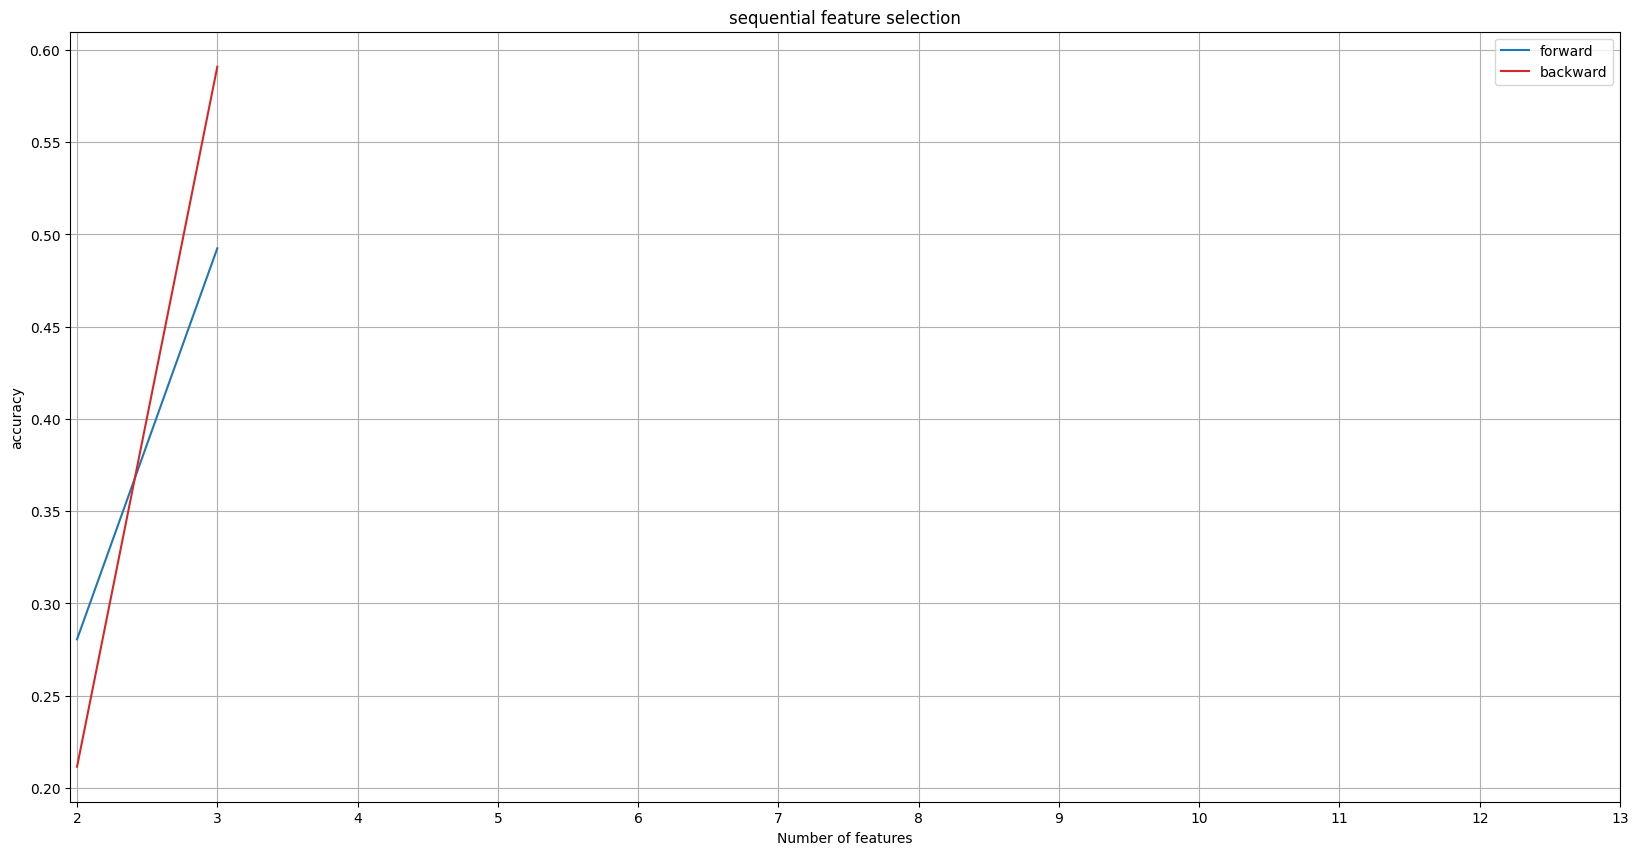

In [14]:
import matplotlib
col = matplotlib.colormaps['tab20']
colors = {'forward': col.colors[0], 'backward': col.colors[6]}

plt.figure(figsize=(20,10)) #(6,4) good size for the report
for j in config['direction']:
    plot_data = scores.loc[scores['direction'] == j]
    print(plot_data)
    plt.plot(plot_data['features'],plot_data['val'],c=colors[j], label = j)


# plt.plot(scores['features'],scores['val'],c=col.colors[6])
# plt.plot(scores['features'],scores['tst'],c=col.colors[7])

plt.ylabel('accuracy')
plt.xlabel('Number of features')
plt.title('sequential feature selection')
plt.legend()
plt.grid(True)
plt.xticks(range(2,14))